# WASP-103b: 2D GP with George

## Data Analysis

In [1]:
from glob import glob
import numpy as np
import CONAN
import matplotlib.pyplot as plt

from os.path import basename
import pandas as pd
CONAN.__version__


'3.3.12'

In [2]:
from CONAN.get_files import get_parameters
P          = 0.925545485
BJD_0      =  2457511.944458 -2457000
sys_params = get_parameters("WASP-103")
path       = "data/"


Loading parameters from cache ...


In order to derive different occultation depths for the observations, we will set different filters

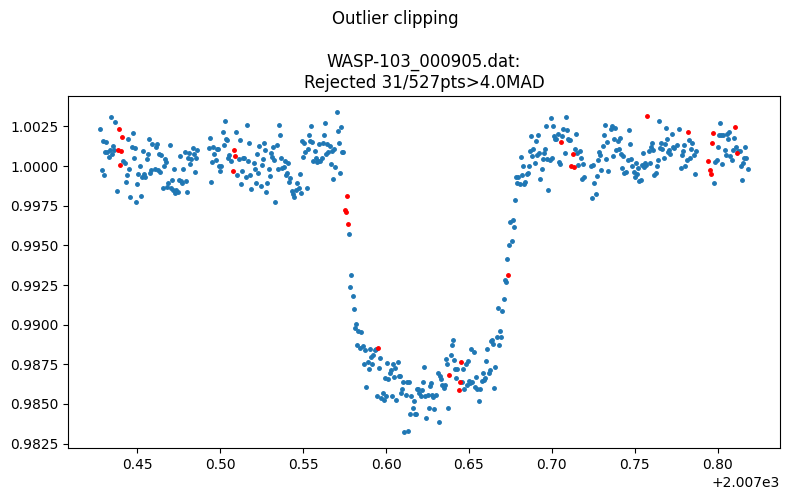

In [3]:
lc_obj = CONAN.load_lightcurves(
                                file_list       = 'WASP-103_000905.dat', 
                                data_filepath   = path, 
                                filters         = "CH",
                                wl              = 0.6)

lc_obj.clip_outliers(   width   = 15, 
                        clip    = 4,     
                        select_column =  ["col1","col6"],
                        niter       = 1,
                        show_plot   = True,
                        verbose     = False)


In [4]:
lc_obj.rescale_data_columns(columns=[3,4,6,7,8],verbose=False)

In [5]:
q1 = (0.4287, 0.0666)
q2 = (0.4023, 0.0284)

In [6]:
t14 = sys_params['planet']['T14'][0]
tra_occ_pars =dict( T_0         = (BJD_0-0.1,BJD_0,BJD_0+0.1),      
                    Period      = (P,5e-8),          
                    Impact_para = (0,0.1,1),      
                    RpRs        = (0.09,0.113,0.13), 
                    Duration    = (0.8*t14, t14, 1.2*t14))
tra_occ_pars

{'T_0': (511.84445799989624, 511.94445799989626, 512.0444579998963),
 'Period': (0.925545485, 5e-08),
 'Impact_para': (0, 0.1, 1),
 'RpRs': (0.09, 0.113, 0.13),
 'Duration': (0.08643333333333333, 0.10804166666666666, 0.12965)}

In [7]:
lc_obj.add_GP(  lc_list     = "all",
                par         = ("col5",     "col8"),
                kernel      = ( "mat32",    "mat32"),
                operation   = "+",
                amplitude   = ( (1,200, 1000), (1,200,1000) ),
                lengthscale = ((0.1, 10, 50),  (0.01, 0.5, 1.5) ),
                gp_pck      = "ge"
            )


# ============ Input lightcurves, filters baseline function =======================================================
name                flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-103_000905.dat CH  0.6  |None c16:W15C4n1  med_sub |  n    0    0    0    0    0    0    0|n    1 ge None           
# ============ Photometry GP properties (start newline with name of * or + to Xply or add a 2nd gp to last file) =========
name/filt           kern  par    h1:[Amp]           h2:[len_scale1]    h3:[Q,η,C,α,b]     h4:[P]       
all                 mat32 col5   U(1,200,1000)      U(0.1,10,50)       None               None        
                |+| mat32 col8   U(1,200,1000)      U(0.01,0.5,1.5)    None               None        


### Least squares fit

Let's do a least squares fit with this setup 


getting decorr params for lc01: WASP-103_000905.dat (spline=False, sine=False, gp=True, s_samp=False, jitt=0.0ppm)
BEST BIC:484.62, pars:[]

Setting-up parametric baseline model from decorr result
# ============ Input lightcurves, filters baseline function =======================================================
name                flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-103_000905.dat CH  0.6  |None c16:W15C4n1  med_sub |  n    0    0    0    0    0    0    0|n    1 ge None           
Total number of baseline parameters: 0

Setting-up transit pars from input values
# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
rho_star/[Duration]        y   	U(0.08643333333333333,0.10804166666666666,0.12965)	#choice in []|unit(gcm^-3/days)
--------repeat this line & params below for multisystem,

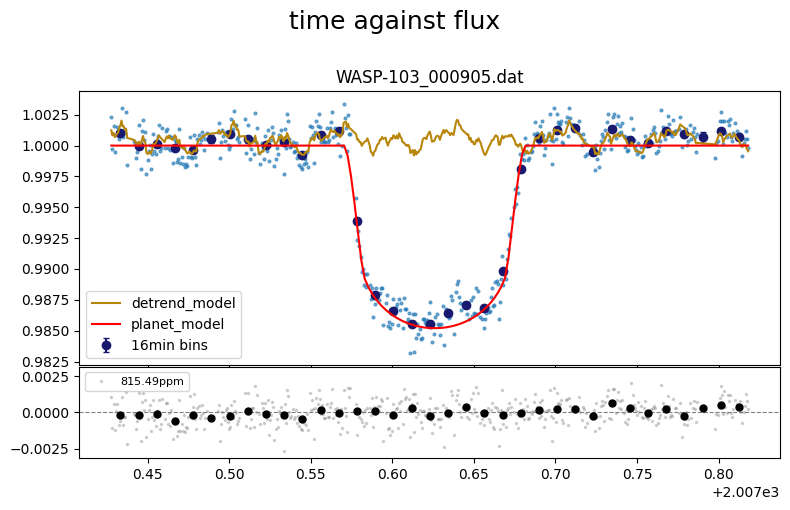

In [8]:
decorr_res = lc_obj.get_decorr( 
                                **tra_occ_pars, 
                                q1              = q1,
                                q2              = q2,
                                delta_BIC       = -5, 
                                exclude_cols    = [0,3,4,5,6,7,8], 
                                setup_planet    = True,
                                show_steps      = False,
                                use_jitter_est  = False,
                                cont            = 0.092)

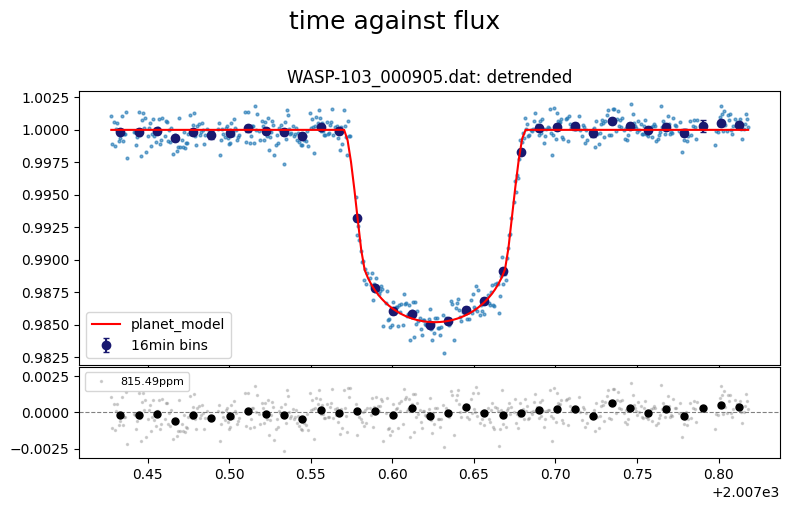

In [9]:
lc_obj.plot(show_decorr_model=True, detrend=True, phase_plot=0)

In [10]:
decorr_res[0]

Let's plot the residual of this least-square fit

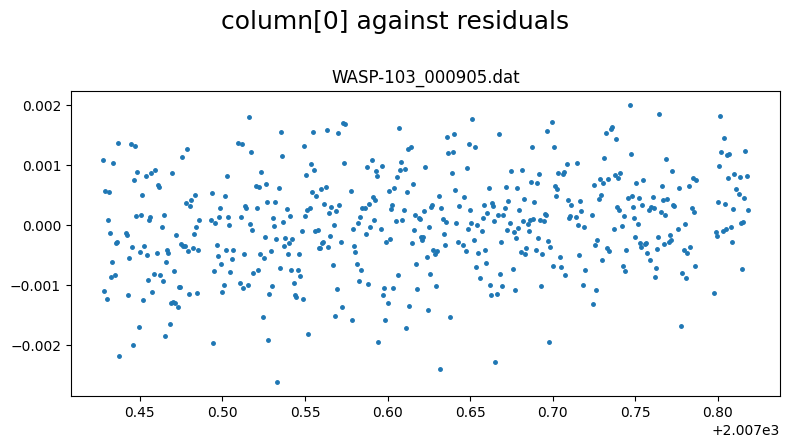

In [11]:
lc_obj.plot((0,"res"), show_decorr_model=True)

Show the correlation of the flux with column 5

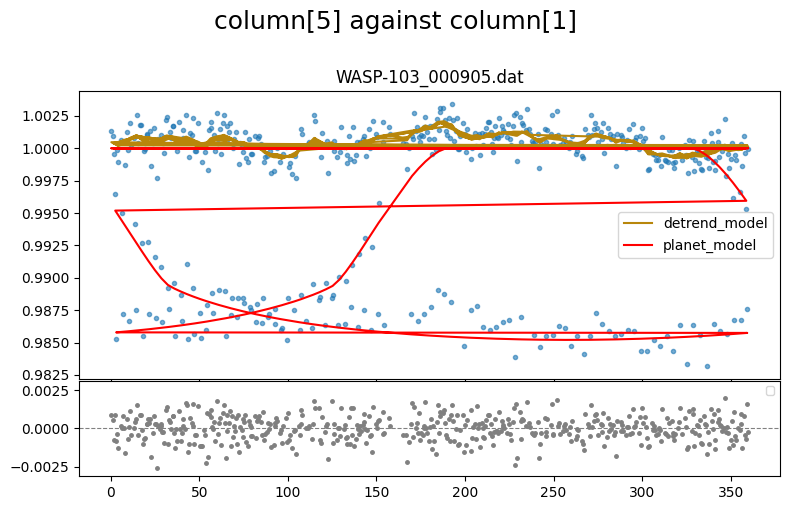

In [12]:
lc_obj.plot((5,1),show_decorr_model=True, detrend=False, binsize=16/(24*60), phase_plot=0)

### setup fit

In [13]:
fit_obj = CONAN.fit_setup(  R_st = sys_params["star"]["radius"], 
                            M_st = sys_params["star"]["mass"], 
                            apply_LCjitter = "y")

fit_obj.sampling(sampler="dynesty",n_cpus=10,n_live=300)

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(1.436,0.052)
Mass_[Msun]    N(1.22,0.039)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Rrho
# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    300 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])   

In [14]:
fit_obj.print()

# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    300 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])            auto 
RVjitter_lims(auto/[lo,hi])               auto 
LCbasecoeff_lims(auto/[lo,hi])            auto 
RVbasecoeff_lims(auto/[lo,hi])            auto 
Light_Travel_Time_correction(y/n)         n 
apply_LC_GPndim_jitter(y/n)        

### Save and load config file

In [15]:
CONAN.create_configfile(lc_obj,None,fit_obj,filename="WASP103_CHEOPS_2D_GP_george.dat")

configuration file saved as WASP103_CHEOPS_2D_GP_george.dat
configuration file saved as WASP103_CHEOPS_2D_GP_george.yaml


In [16]:
import CONAN
lc_obj,rv_obj,fit_obj = CONAN.load_configfile("WASP103_CHEOPS_2D_GP_george.dat")

# ============ Input lightcurves, filters baseline function =======================================================
name                flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-103_000905.dat CH  0.6  |None c16:W15C4n1  med_sub |  n    0    0    0    0    0    0    0|n    1 ge None           


lightcurves from filepath: data/
1 transiting planet(s)
Order of unique filters: ['CH']

In [3]:
fit_obj.print()

# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    300 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])            auto 
RVjitter_lims(auto/[lo,hi])               auto 
LCbasecoeff_lims(auto/[lo,hi])            auto 
RVbasecoeff_lims(auto/[lo,hi])            auto 
Light_Travel_Time_correction(y/n)         n 
apply_LC_GPndim_jitter(y/n)        

In [2]:
CONAN.get_parameter_names(lc_obj,None,fit_obj)[1]

{'Duration': 'U(0.08643333333333333,0.10804166666666666,0.12965)',
 'T_0': 'U(511.84445799989624,511.94445799989626,512.0444579998963)',
 'RpRs': 'U(0.09,0.113,0.13)',
 'Impact_para': 'U(0,0.1,1)',
 'Period': 'N(0.925545485,5e-08)',
 'CH_q1': 'N(0.4287,0.0666)',
 'CH_q2': 'N(0.4023,0.0284)',
 'lc1_logjitter': 'U(-15.0000,-8.3116,-4.7217)',
 'GPlc1_Amp1_col5': 'U(1,200,1000)',
 'GPlc1_len1_col5': 'U(0.1,10,50)',
 'GPlc1_Amp2_col8': 'U(1,200,1000)',
 'GPlc1_len2_col8': 'U(0.01,0.5,1.5)'}

### Run  fit

In [3]:
result = CONAN.run_fit(lc_obj, None, fit_obj, 
                        out_folder="result_WASP103_CHEOPS_2D_GP_george",
                        rerun_result=True
                        )

Fit result already exists in this folder: result_WASP103_CHEOPS_2D_GP_george
Rerunning CONAN with saved posterior chains to regenerate plots and files...

load_rvs(): loading RVs from path - /Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN/Notebooks/WASP-103/
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.
configuration file saved as result_WASP103_CHEOPS_2D_GP_george/config_save.dat

================ CONAN fit launched!!! ================

Setting up photometry arrays ...
Setting up photometry GPs ...

Plotting prior distributions ...
----------------------------------

Generating initial model(s) ...
--------------------------- [0.04 secs]

Plotting initial model(s) ...
--------------------------- [1.74 secs]

Fit setup
----------
No of cpus: 10
No of dimensions: 12
fitting parameters:  ['Duration' 'T_0' 'RpRs' 'Impact_para' 'Period' 

### load result

In [4]:
import CONAN
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

result = CONAN.load_result("result_WASP103_CHEOPS_2D_GP_george")


['lc'] Output files, ['WASP-103_000905_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load lightcurves.
['rv'] Output files, [], loaded into result object
load_rvs(): input_rv is provided, using it to load rvs.
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.


In [8]:
result.lc.GP['WASP-103_000905.dat'].gp.get_parameter_dict()

OrderedDict([('kernel:k1:k1:log_constant', -15.234139330127007),
             ('kernel:k1:k2:metric:log_M_0_0', 5.200939977834735),
             ('kernel:k2:k1:log_constant', -14.751195369171885),
             ('kernel:k2:k2:metric:log_M_0_0', -0.709930881935139)])

We can check if there are still any correlations between the residuals and the cotrending vectors


getting decorr params for lc01: WASP-103_000905.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:486.78, pars:[]

Setting-up parametric baseline model from decorr result
# ============ Input lightcurves, filters baseline function =======================================================
name                flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-103_000905.dat CH  0.6  |None None         None    |  n    0    0    0    0    0    0    0|n    1 n  None           
Total number of baseline parameters: 0


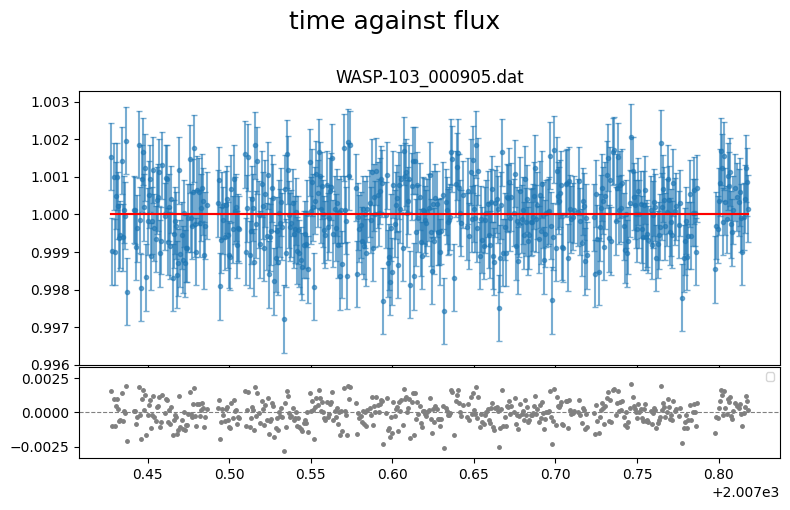

In [2]:
res_corr = result.lc.check_corr(fit_offset="n", delta_BIC=-5)

There are no significant correlations left in the residuals

In [3]:
result.params_dict

{'Duration': 0.11060603470398254+/-0.0006743160444396615,
 'T_0': 511.94453591002923+/-0.00019900574702091944,
 'RpRs': 0.11207642131163673+/-0.0008564380472150523,
 'Impact_para': 0.16771550675584992+/-0.09480373932366967,
 'Period': 0.925545482881369+/-4.946725468135682e-08,
 'CH_q1': 0.30519902052649717+/-0.04223350213719179,
 'CH_q2': 0.38898839647580125+/-0.02810766157423364,
 'lc1_logjitter': -11.264657396739938+/-2.5888577264314225,
 'GPlc1_Amp1_col5': 490.73321723901597+/-97.90373773435346,
 'GPlc1_len1_col5': 13.47017310532421+/-4.973540986210983,
 'GPlc1_Amp2_col8': 626.5796060863466+/-246.43390182281112,
 'GPlc1_len2_col8': 0.7059849988220878+/-0.38741658900076964}

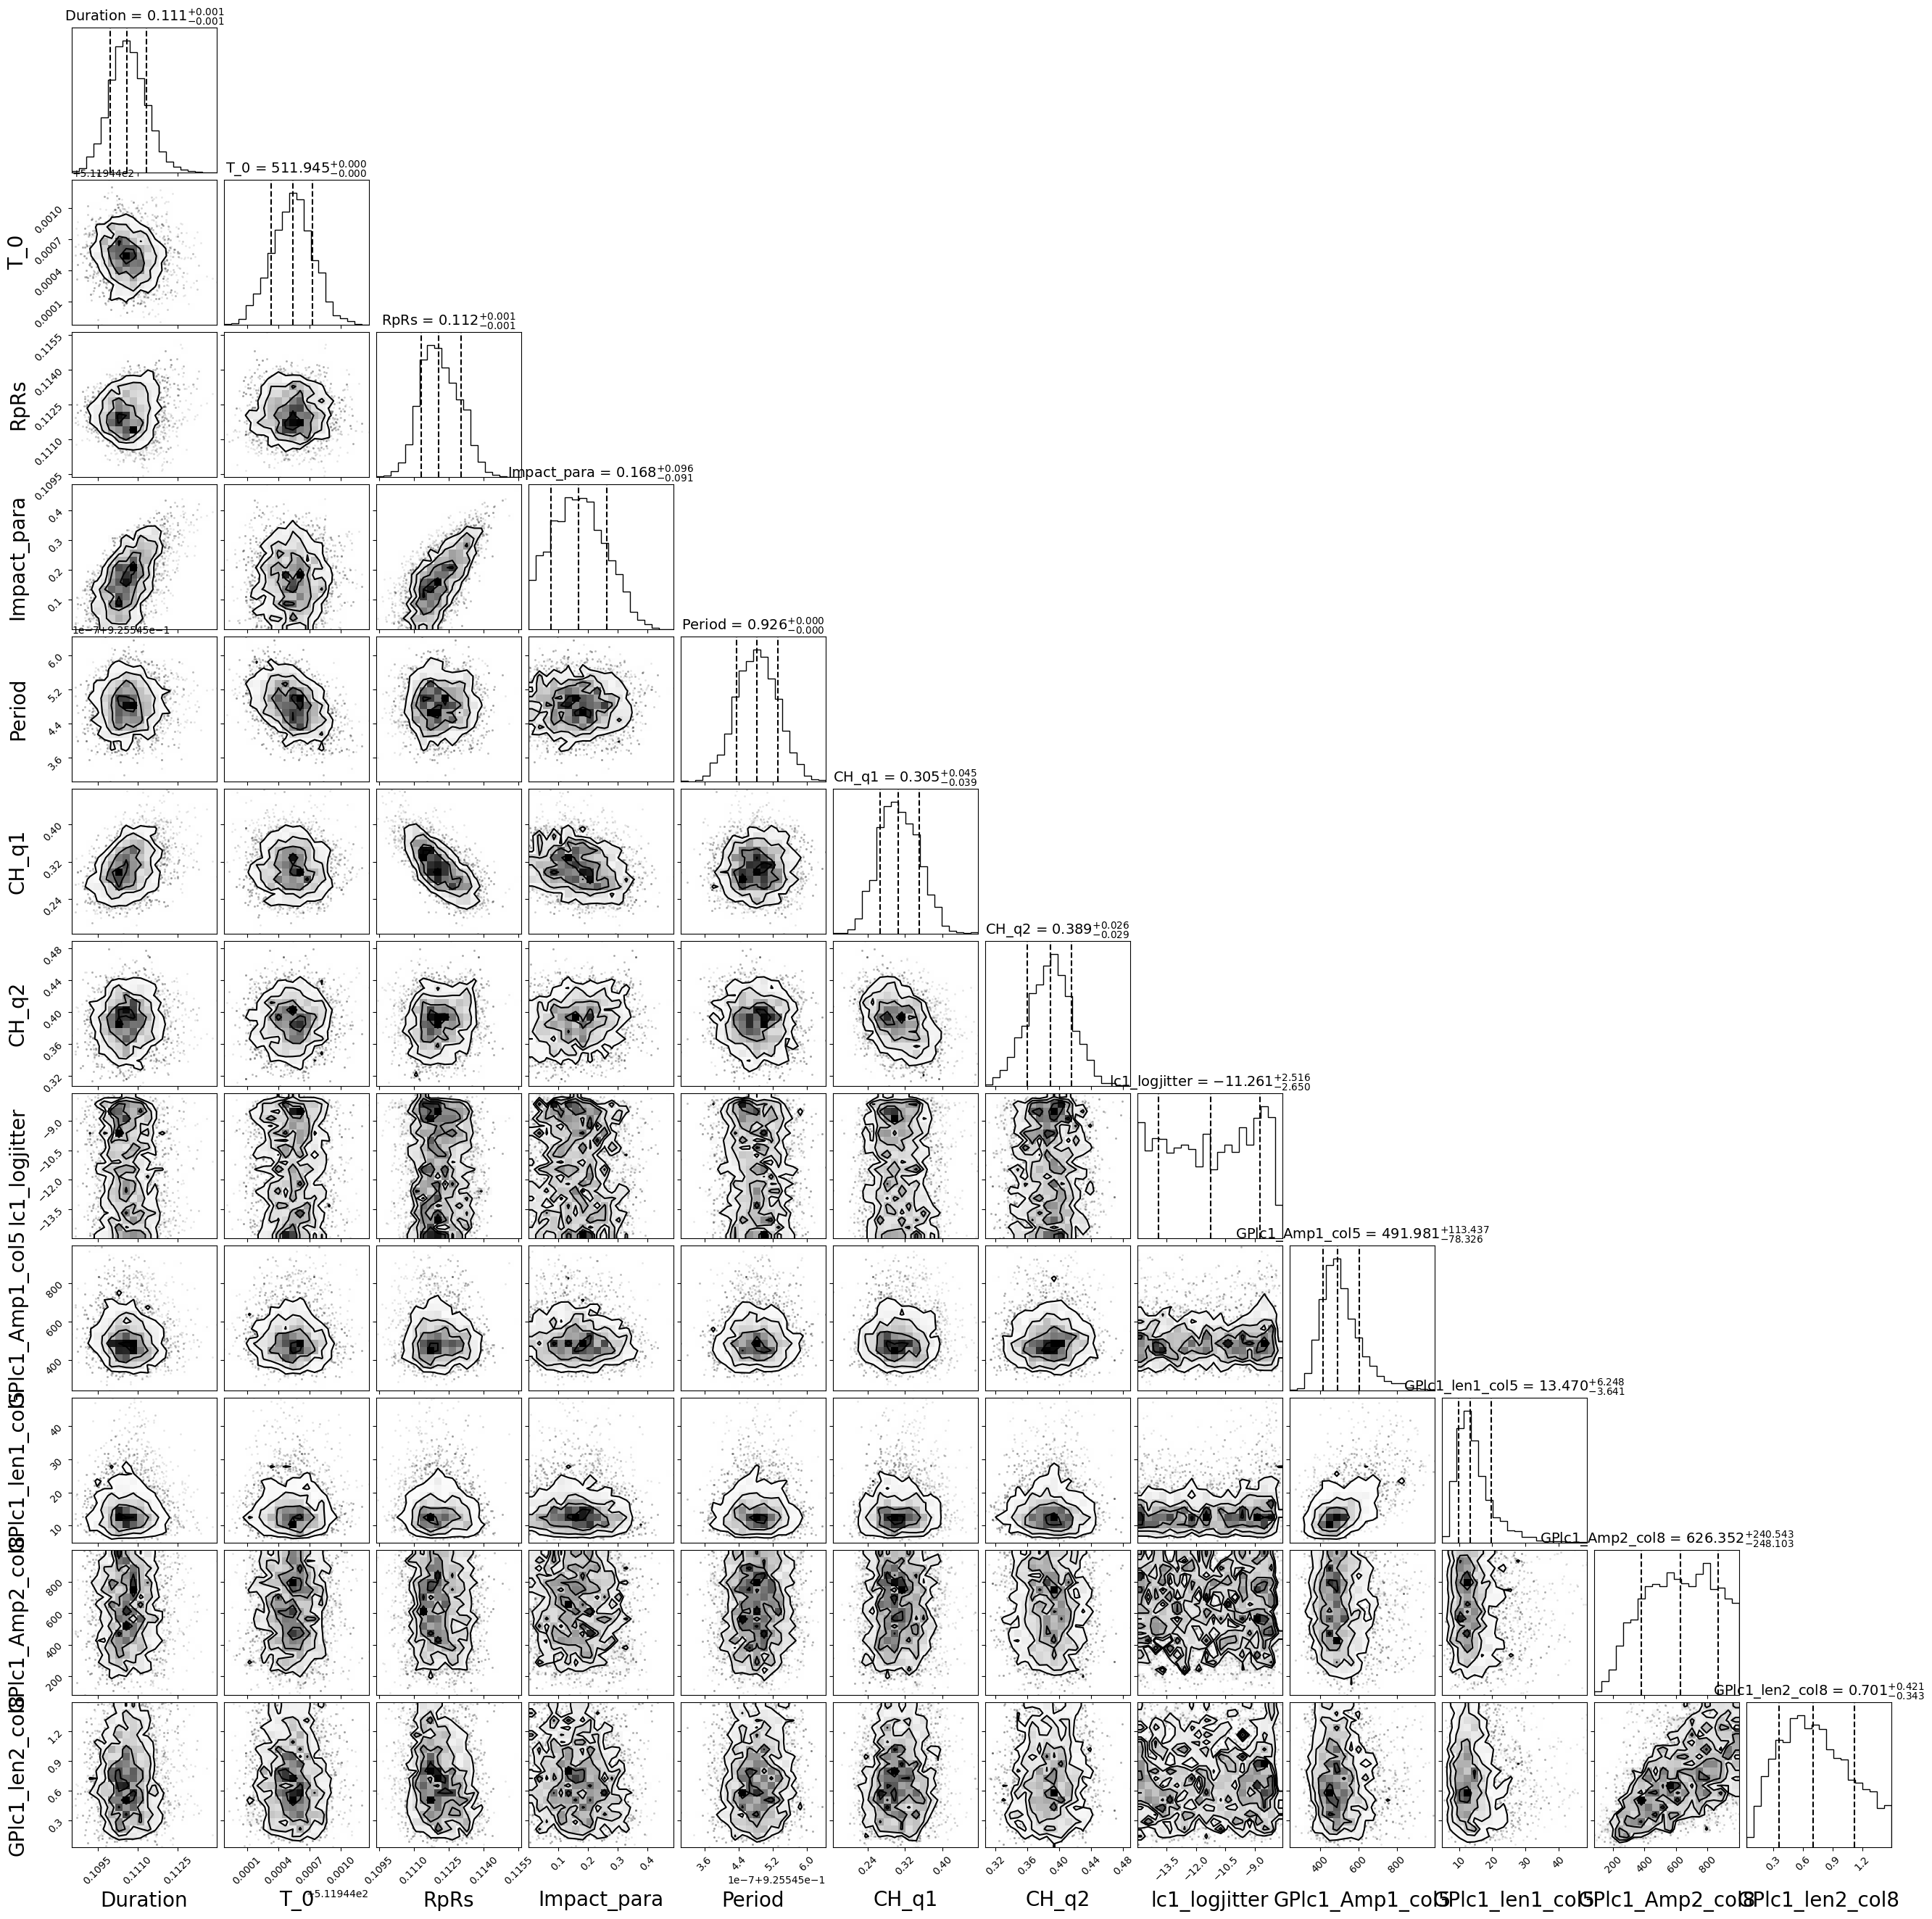

In [4]:
result.plot_corner();

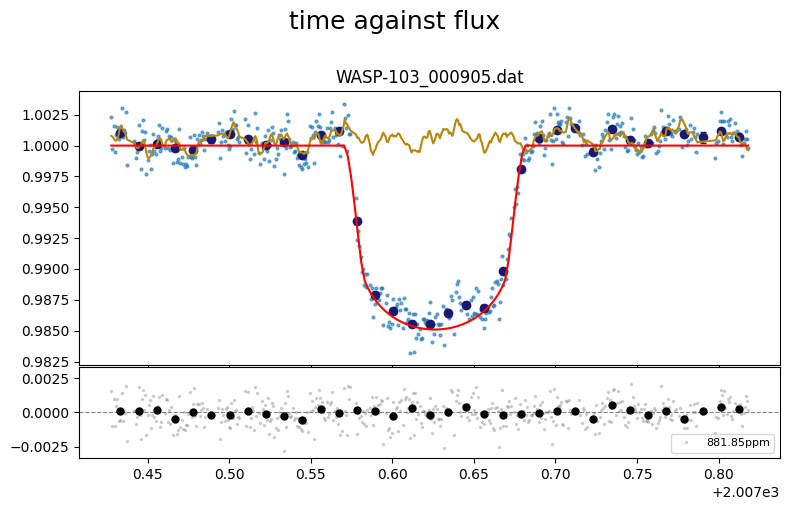

In [6]:
result.lc.plot_bestfit();

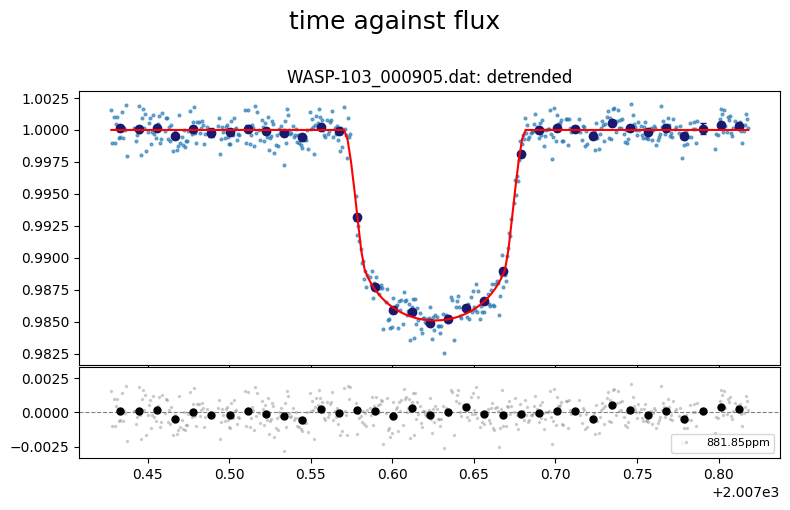

In [7]:
result.lc.plot_bestfit(detrend=True);

The GP object is stored in 

In [14]:
result.lc.GP['WASP-103_000905.dat']

GPSaveObj(WASP-103_000905.dat: kernel=['ge_mat32', 'ge_mat32'], ndim=2, cols=('col5', 'col8'), cols_err=None)